<h1> IMU action classification </h1>

data import

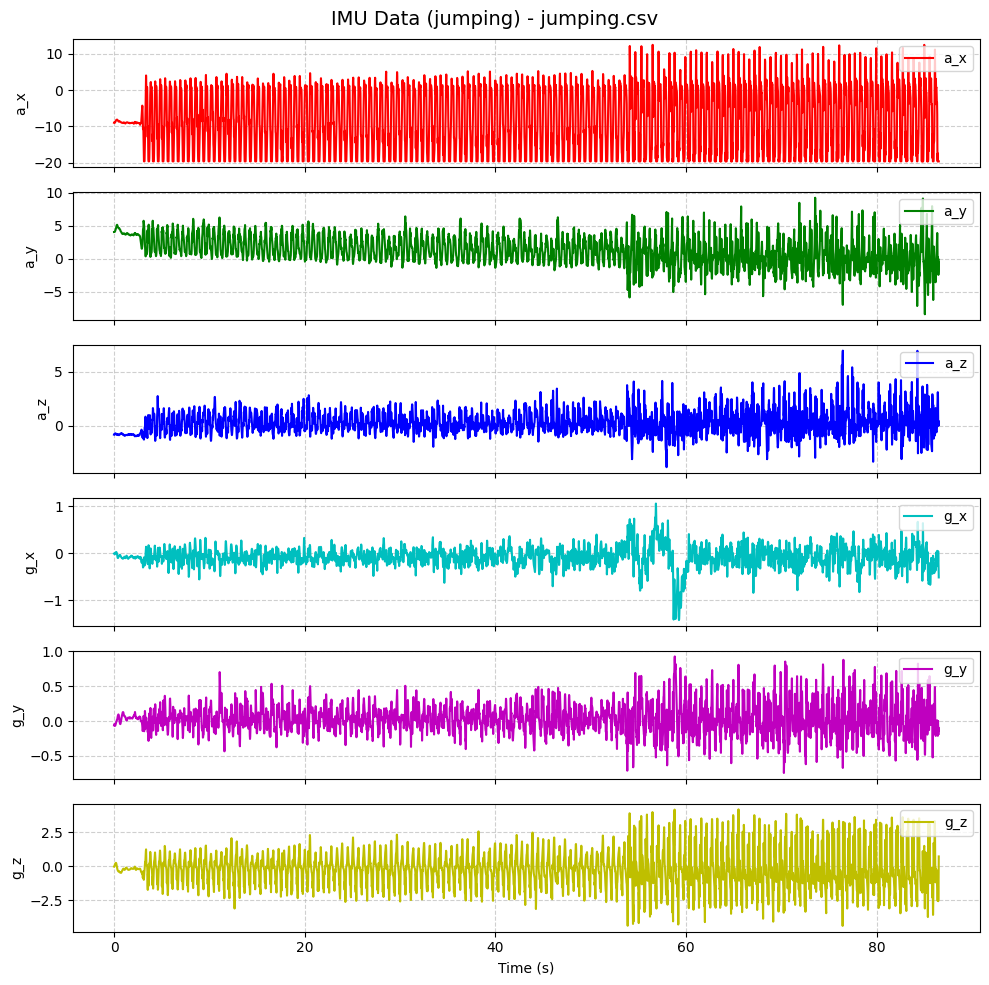

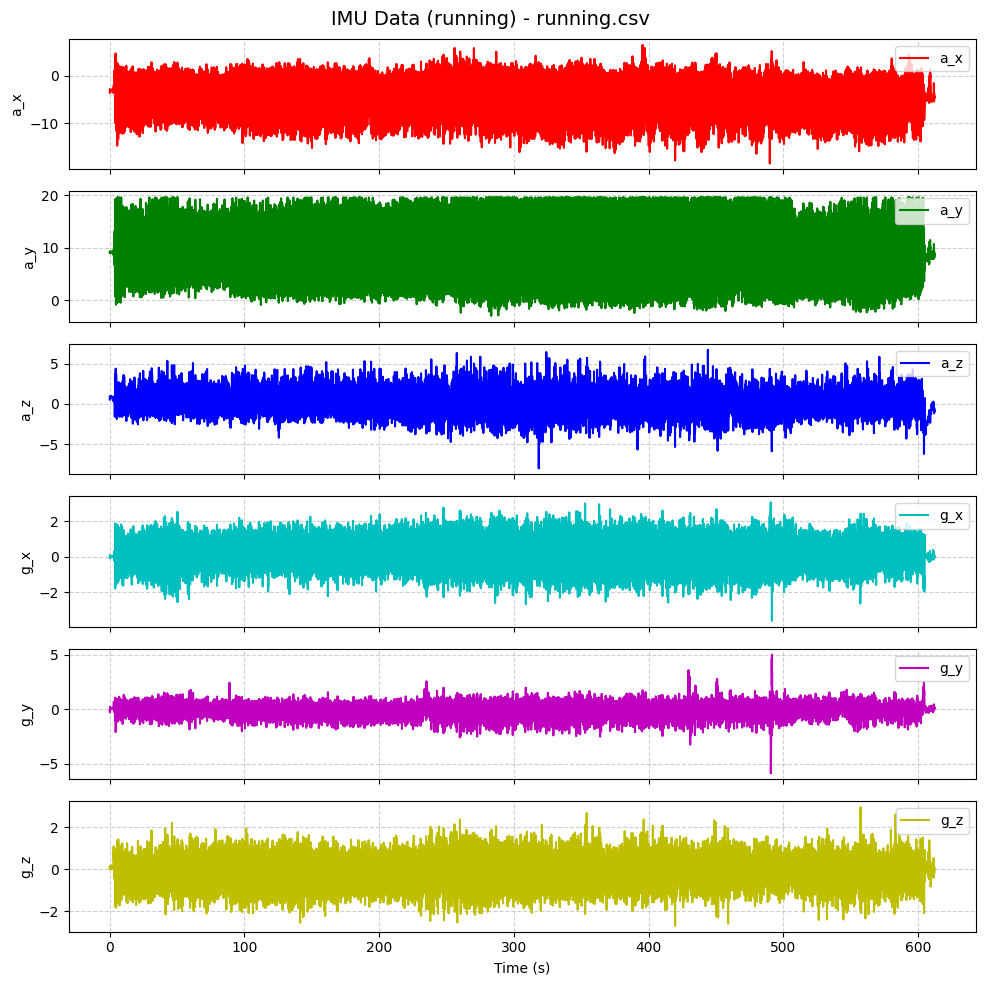

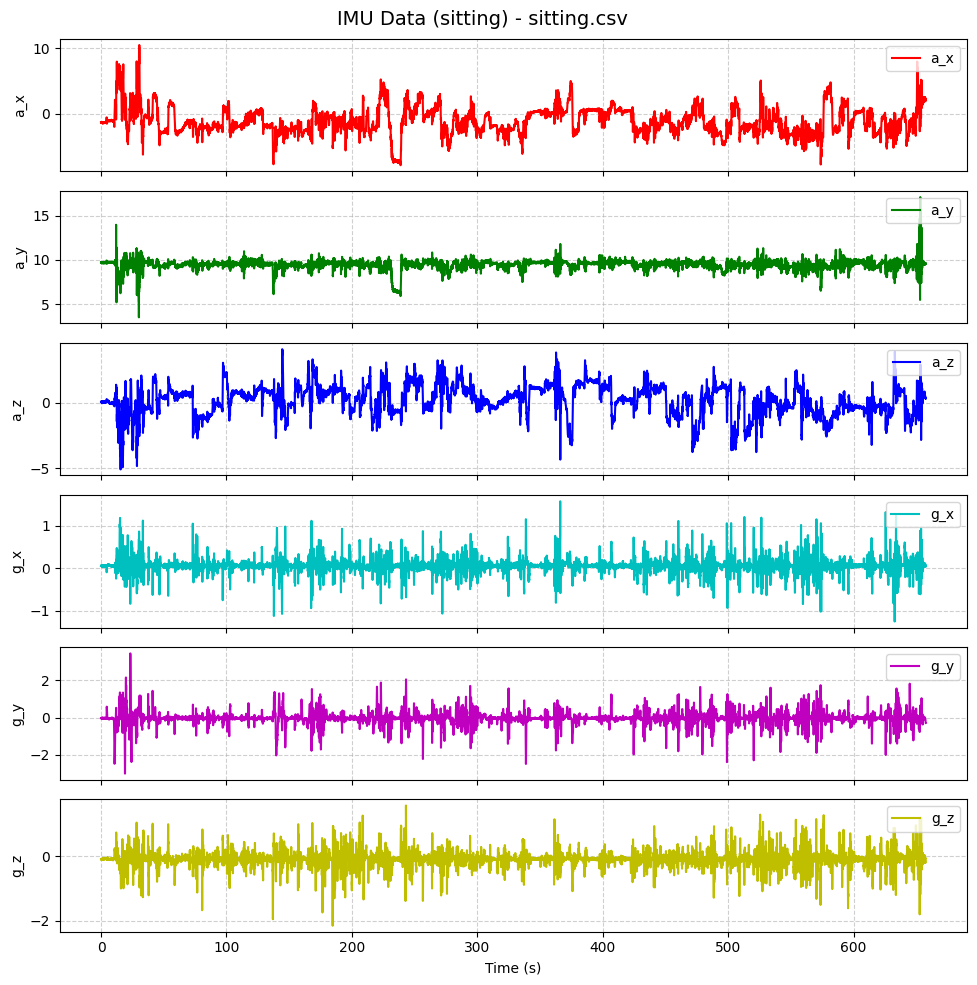

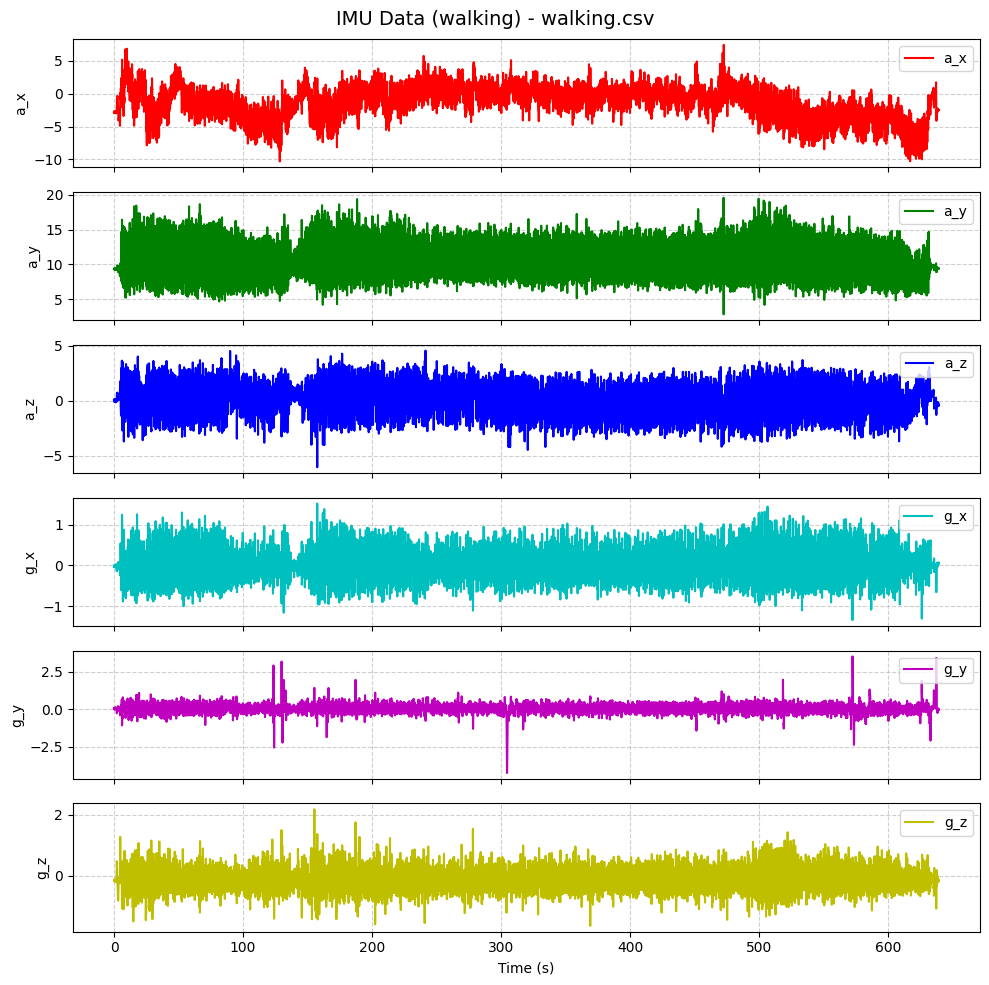

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# === CONFIG ===
DATA_FOLDER = "imu_dataset"  # Change this to your dataset folder
SAMPLING_FREQ = 50  # IMU sampling rate (Hz)
SEGMENT_LENGTH = 1  # Window size in seconds
WINDOW_SIZE = SAMPLING_FREQ * SEGMENT_LENGTH  # 50 samples per segment

# === FUNCTION TO PLOT RAW SIGNALS ===
def plot_imu_signals(df, label, file_name):
    time_axis = np.arange(len(df)) / SAMPLING_FREQ  # Convert index to seconds
    
    fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True)
    imu_signals = ["a_x", "a_y", "a_z", "g_x", "g_y", "g_z"]
    colors = ["r", "g", "b", "c", "m", "y"]
    
    for i, signal in enumerate(imu_signals):
        axs[i].plot(time_axis, df[signal], label=signal, color=colors[i])
        axs[i].set_ylabel(signal)
        axs[i].legend(loc="upper right")
        axs[i].grid(True, linestyle="--", alpha=0.6)

    axs[-1].set_xlabel("Time (s)")
    fig.suptitle(f"IMU Data ({label}) - {file_name}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

# === FUNCTION TO LOAD AND EXTRACT FEATURES ===
def load_data(folder):
    all_data = []
    all_labels = []
    
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            file_path = os.path.join(folder, file)
            label = file.split(".")[0]  # Assuming filename starts with class label
            df = pd.read_csv(file_path)
            
            # Extract only necessary columns
            imu_columns = ["a_x", "a_y", "a_z", "g_x", "g_y", "g_z"]
            df = df[imu_columns]  # Ensure only IMU columns are used
            
            # Plot raw IMU signals for visualization
            plot_imu_signals(df, label, file)

            # Convert to numpy array
            data_array = df.values
            
            # Segment into 1-second windows (50 samples each)
            for i in range(0, len(data_array) - WINDOW_SIZE, WINDOW_SIZE):
                segment = data_array[i : i + WINDOW_SIZE]
                
                # Compute statistical features
                features = segment.mean(axis=0).tolist() + segment.var(axis=0).tolist()
                
                all_data.append(features)
                all_labels.append(label)
    
    return np.array(all_data), np.array(all_labels)

# === LOAD AND PREPROCESS DATA ===
X, y = load_data(DATA_FOLDER)
class_labels = np.unique(y)  # Ensures correct order of labels

# === SPLIT INTO TRAIN & TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Visualization

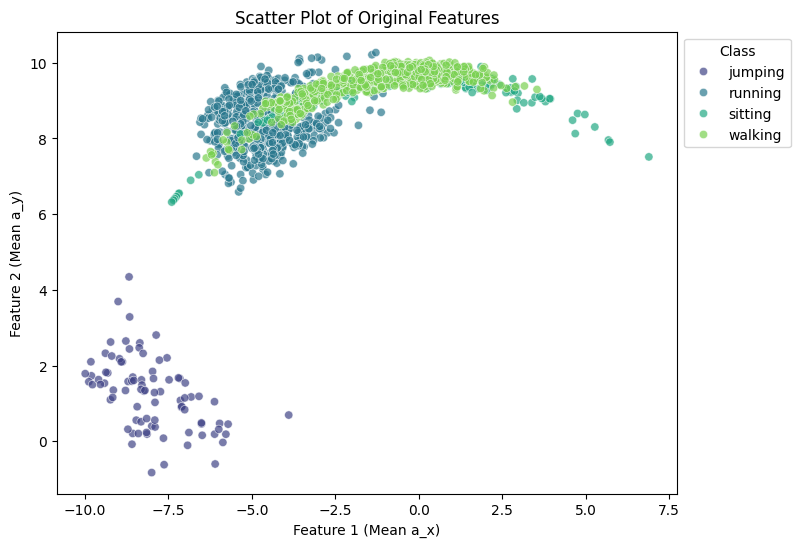

<Figure size 800x600 with 0 Axes>

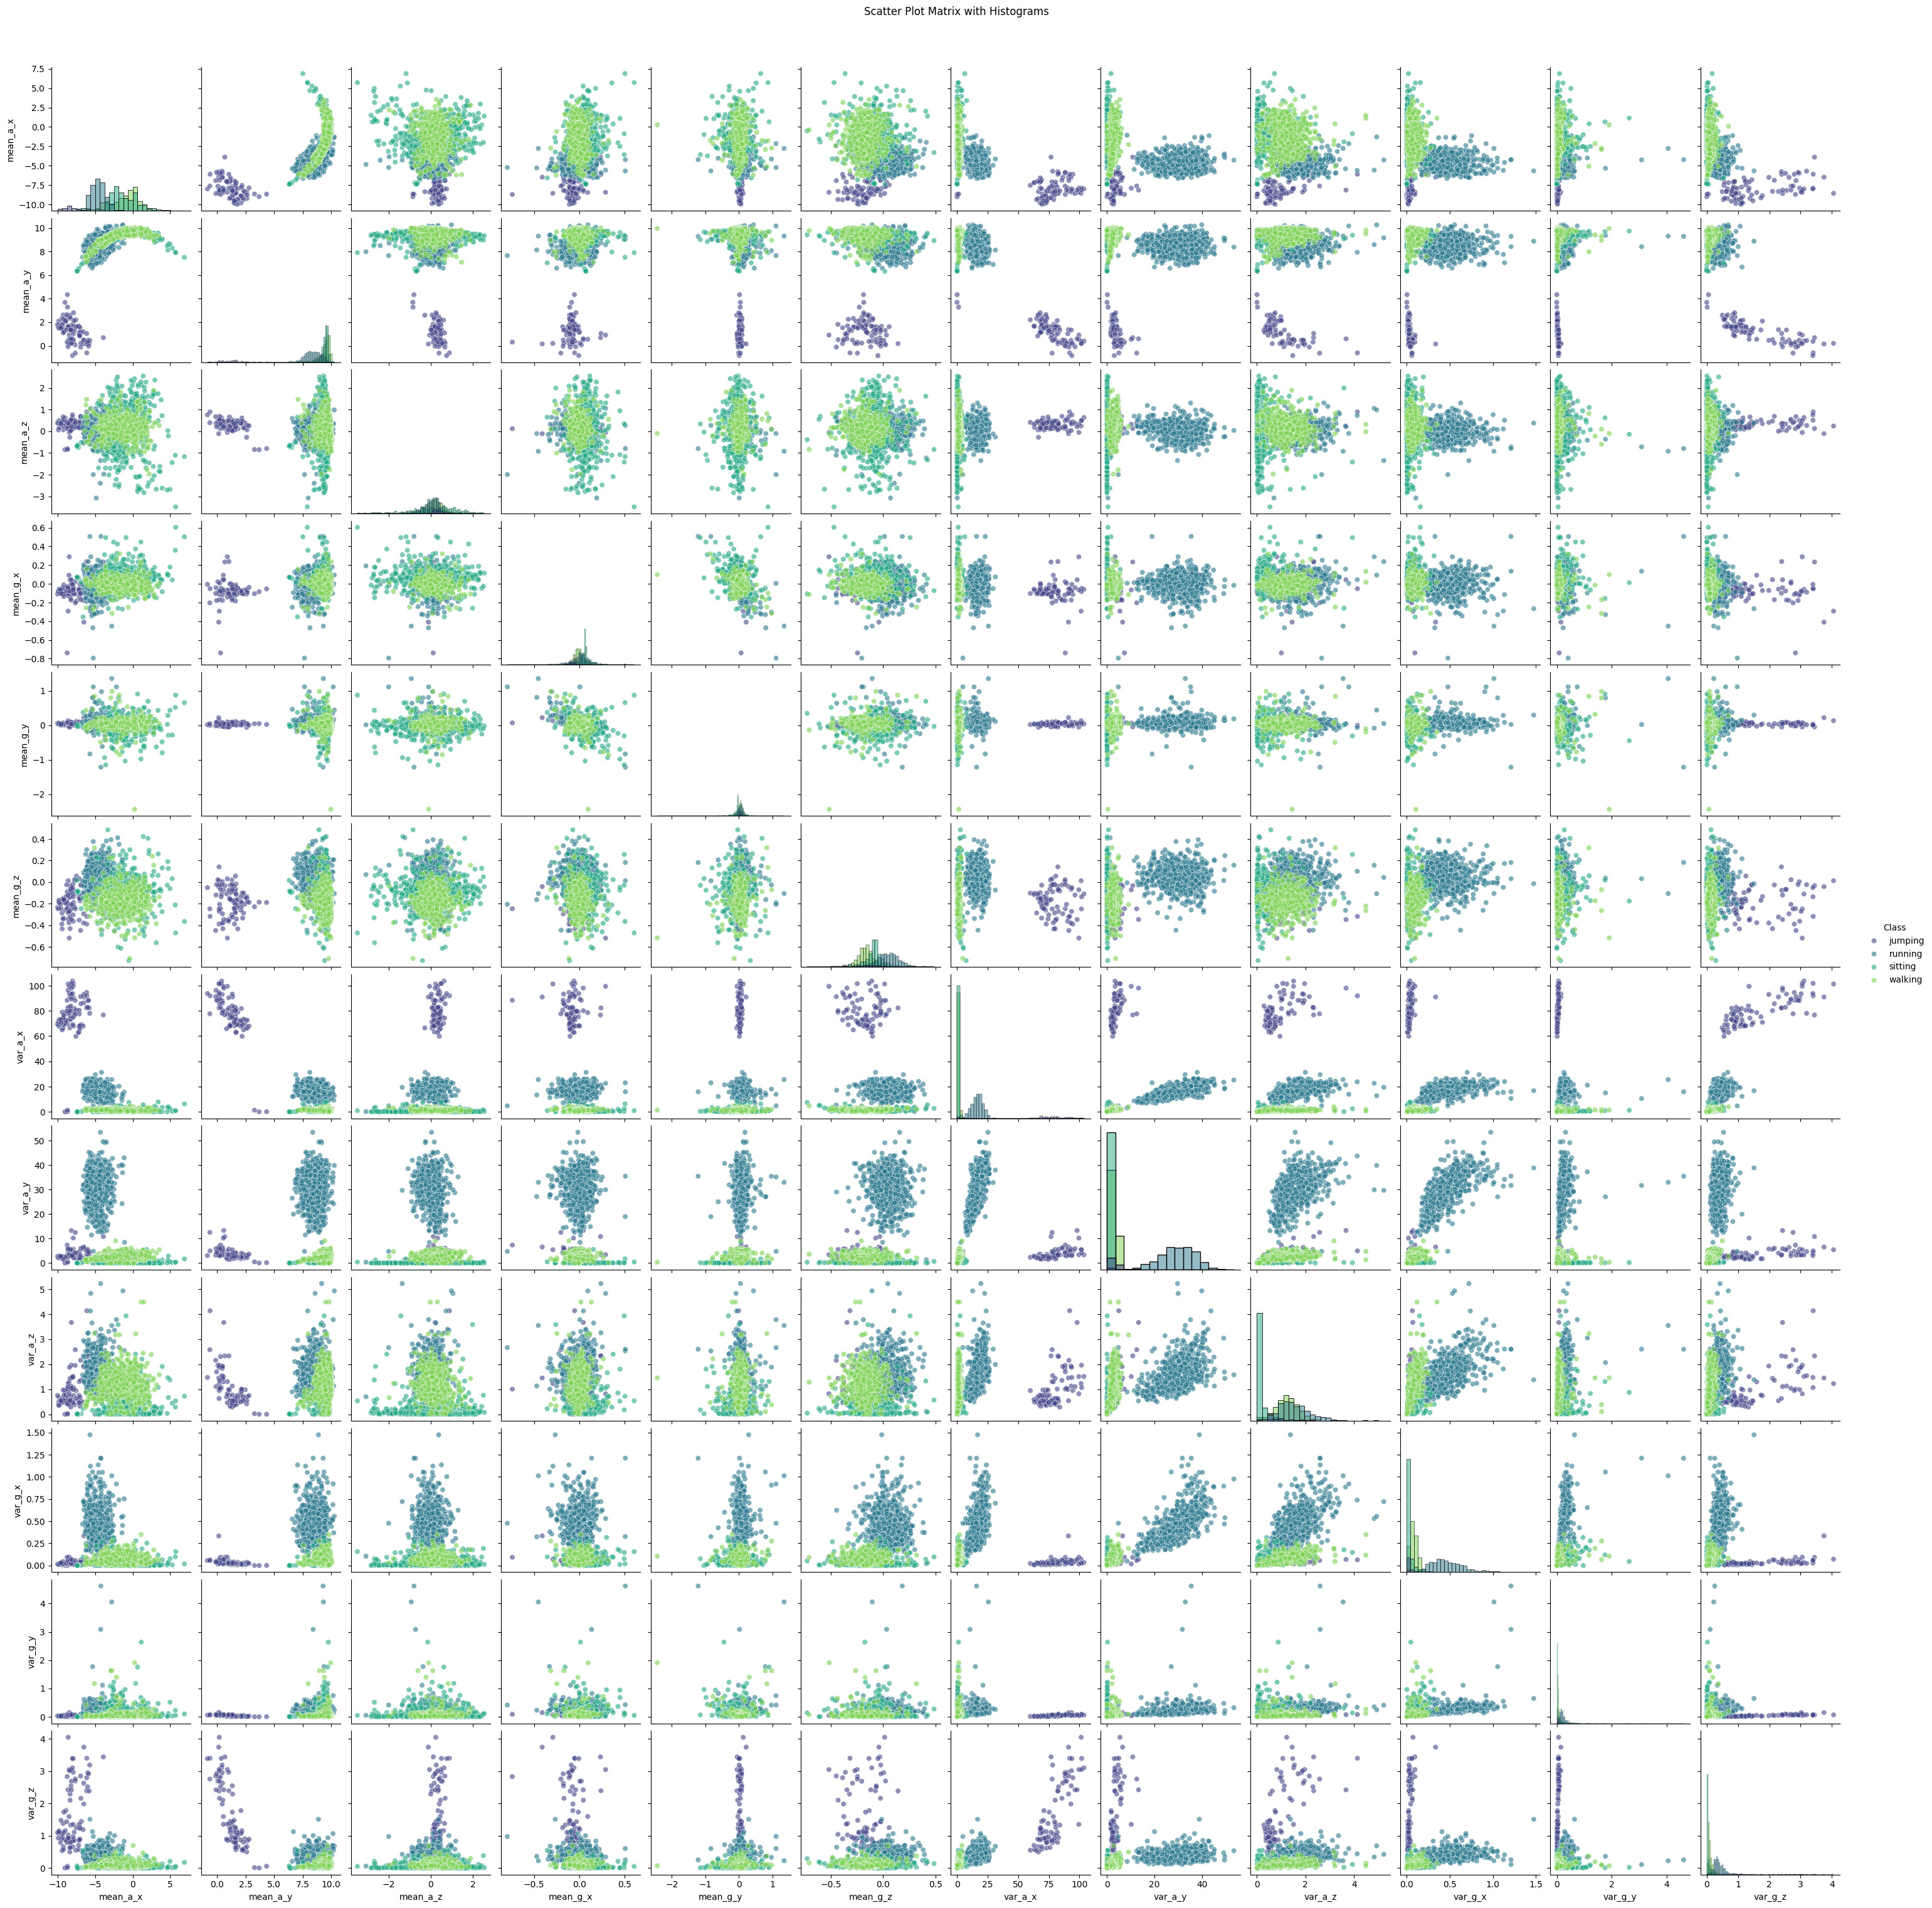

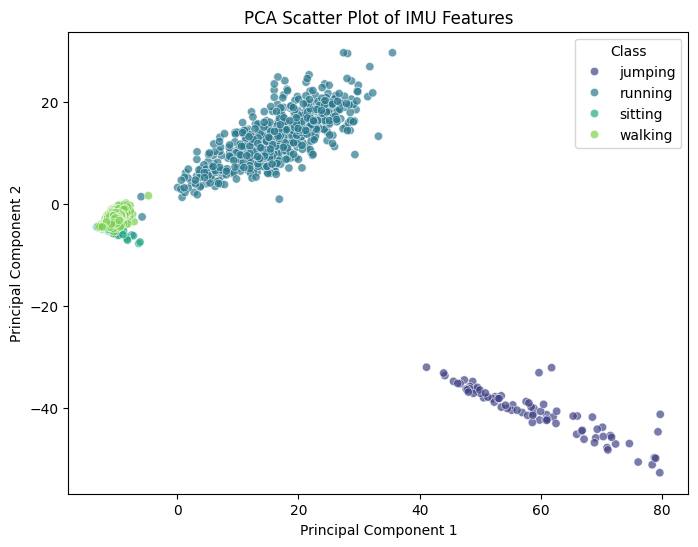

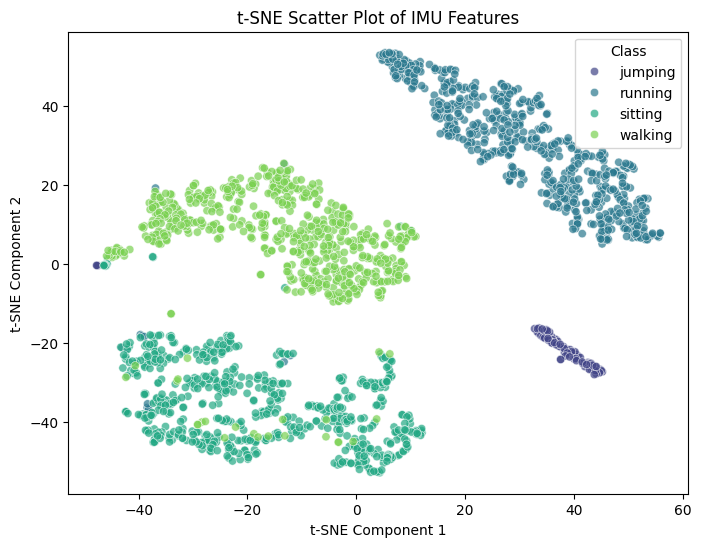

In [26]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# === DATA VISUALIZATION ===

# 1. Scatter Plot of Original Features (First Two Features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("Feature 1 (Mean a_x)")
plt.ylabel("Feature 2 (Mean a_y)")
plt.title("Scatter Plot of Original Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()


# 2. Full Scatter Plot
# Convert to DataFrame for easier visualization
feature_names = ["mean_a_x", "mean_a_y", "mean_a_z", "mean_g_x", "mean_g_y", "mean_g_z",
                 "var_a_x", "var_a_y", "var_a_z", "var_g_x", "var_g_y", "var_g_z"]
df_features = pd.DataFrame(X, columns=feature_names)
df_features["Class"] = y  # Add class labels for visualization
plt.figure(figsize=(8, 6))
sns.pairplot(df_features, hue="Class", diag_kind="hist", palette="viridis", plot_kws={'alpha':0.6})
plt.suptitle("Scatter Plot Matrix with Histograms", y=1.02)
plt.show()

# 3. PCA Scatter Plot (First Two Principal Components)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of IMU Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()

# 4. t-SNE Scatter Plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot of IMU Features")
plt.legend(title="Class", bbox_to_anchor=(1, 1))
plt.show()

Accuracy: 0.9674185463659147
              precision    recall  f1-score   support

     jumping       1.00      0.88      0.94        17
     running       1.00      0.98      0.99       122
     sitting       0.92      0.99      0.96       132
     walking       0.98      0.95      0.96       128

    accuracy                           0.97       399
   macro avg       0.98      0.95      0.96       399
weighted avg       0.97      0.97      0.97       399



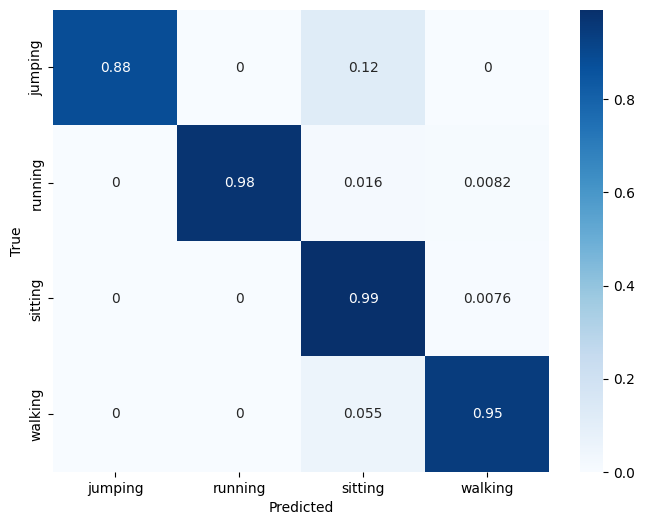

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# === TRAIN SVM CLASSIFIER ===
svm_model = SVC(kernel="linear", C=0.1, gamma="auto")
svm_model.fit(X_train, y_train)


# === EVALUATE MODEL ===
y_pred = svm_model.predict(X_test)

# === PRINT EVALUATION METRICS ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === PLOT CONFUSION MATRIX ===
# get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Grid Search

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, 

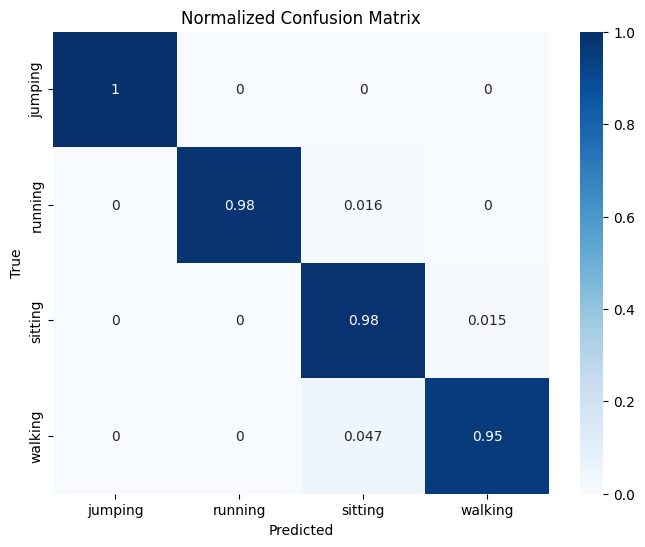

In [38]:
from sklearn.model_selection import GridSearchCV

# === DEFINE HYPERPARAMETER GRID ===
param_grid = {
    "kernel": ["linear", "rbf"],  # Kernel type
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "gamma": ["scale", "auto", 0.01, 0.1, 1]  # Kernel coefficient
}

# === PERFORM GRID SEARCH ===
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=2)
grid_search.fit(X_train, y_train)

# === PRINT BEST PARAMETERS ===
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# === TRAIN SVM WITH BEST PARAMETERS ===
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

# === EVALUATE BEST MODEL ===
y_pred = best_svm.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize

# === PRINT EVALUATION METRICS ===
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === PLOT CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

Test other classifiers


Training SVM (RBF Kernel)...

SVM (RBF Kernel) - Accuracy: 0.9749
              precision    recall  f1-score   support

     jumping       1.00      1.00      1.00        17
     running       1.00      0.98      0.99       122
     sitting       0.94      0.98      0.96       132
     walking       0.98      0.95      0.97       128

    accuracy                           0.97       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.97      0.98       399



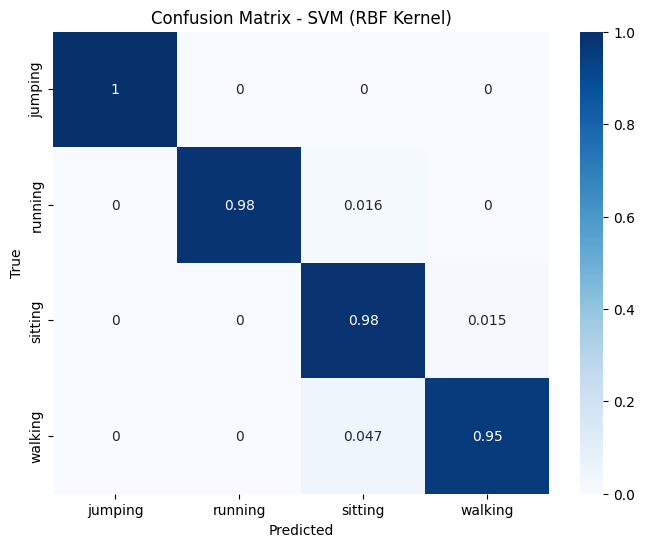


Training Random Forest...

Random Forest - Accuracy: 0.9774
              precision    recall  f1-score   support

     jumping       1.00      1.00      1.00        17
     running       1.00      0.98      0.99       122
     sitting       0.95      0.99      0.97       132
     walking       0.98      0.96      0.97       128

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399



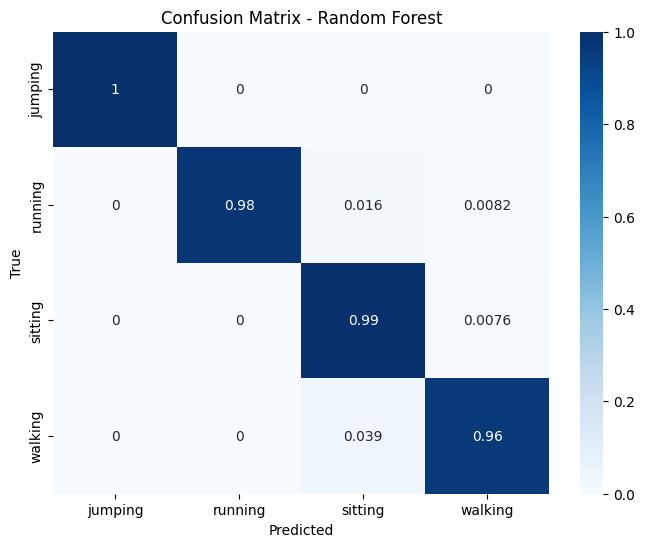


Training K-Nearest Neighbors...

K-Nearest Neighbors - Accuracy: 0.9649
              precision    recall  f1-score   support

     jumping       1.00      0.88      0.94        17
     running       1.00      0.98      0.99       122
     sitting       0.92      0.98      0.95       132
     walking       0.98      0.95      0.96       128

    accuracy                           0.96       399
   macro avg       0.97      0.95      0.96       399
weighted avg       0.97      0.96      0.97       399



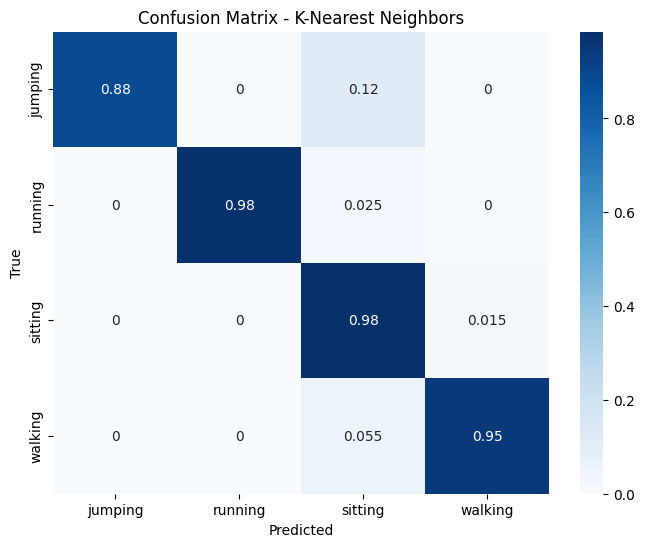


Training Logistic Regression...

Logistic Regression - Accuracy: 0.9699
              precision    recall  f1-score   support

     jumping       1.00      1.00      1.00        17
     running       1.00      0.98      0.99       122
     sitting       0.93      0.98      0.96       132
     walking       0.98      0.94      0.96       128

    accuracy                           0.97       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.97      0.97      0.97       399



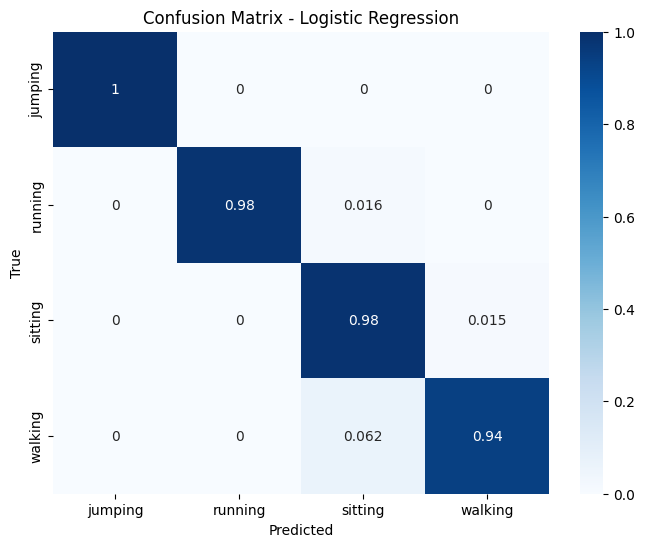

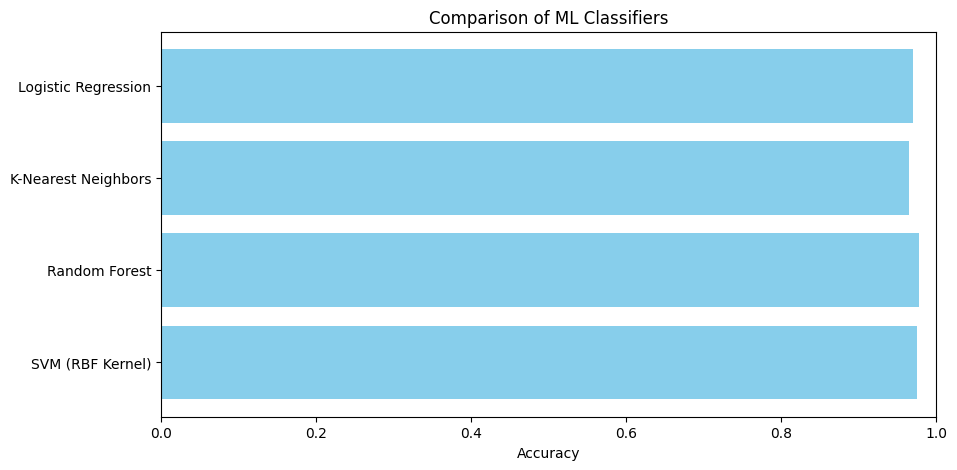

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# === CLASSIFIERS TO TEST ===
models = {
    "SVM (RBF Kernel)": SVC(kernel="rbf", C=10.0, gamma="auto"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=500)
    }

# === TRAIN & EVALUATE EACH MODEL ===
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Compute accuracy
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    
    # Print classification report
    print(f"\n{model_name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# === COMPARE RESULTS ===
plt.figure(figsize=(10, 5))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("Comparison of ML Classifiers")
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


<h1> Emotion Recognition </h1>

<h3>acquire dataset

In [47]:
# Import the EmotionCapture class
from emotion_capture import EmotionCapture  # Make sure the file is in the same directory or in your Python path

# Create an instance of EmotionCapture
emotion_capture = EmotionCapture(capture_time=10)  # Set capture time to 10 seconds

# Start the capture process
emotion_capture.run()  # This will open a window and start capturing faces


Started capturing happy
Done
Started capturing sad
Done


In [11]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    print("GPUs are available")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs found. Using CPU.")

GPUs are available
Device 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


<h3> Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
           Flatten-7                [-1, 16384]               0
            Linear-8                  [-1, 128]       2,097,280
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 1]             129
          Sigmoid-12                    [-1, 1]               0
Total params: 2,116,225
Trainable params: 2,116,225
Non-trainable params: 0
---------------------------

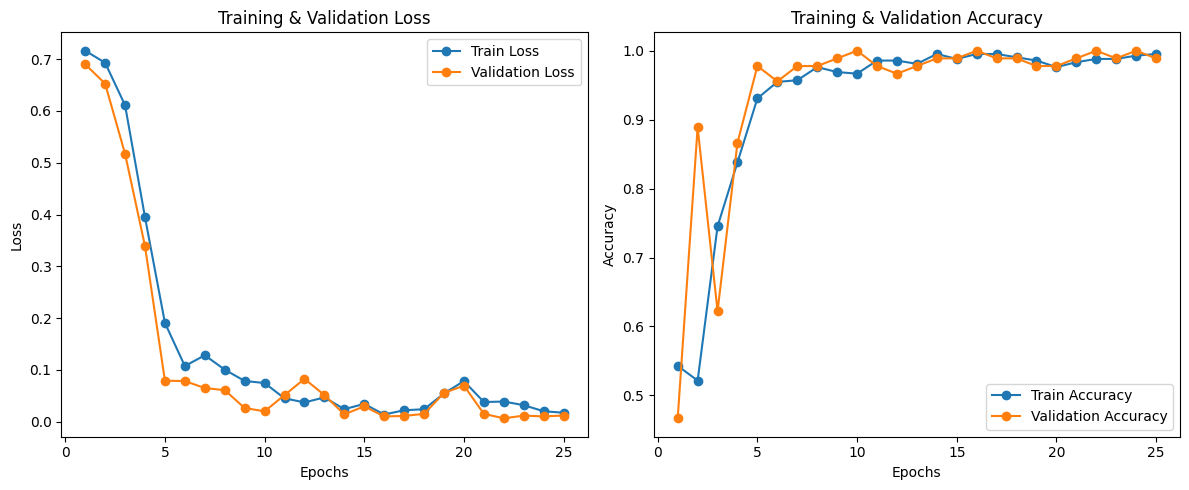

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchsummary import summary


#DATA_AUGMENTATION = False
DATA_AUGMENTATION = True

# === Preprocess Data ===
batch_size = 32

# Define the base transformation without augmentation
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = 'data/emotion'
dataset = datasets.ImageFolder(root=data_dir, transform=base_transform)

# Split the dataset into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Test on a single image at a time

# === Define CNN Model ===
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # Adjust based on output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Create model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
summary(model, (1, 64, 64))


criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #best
#optimizer = optim.Adam(model.parameters(), lr=0.01) #too strong
#optimizer = optim.Adam(model.parameters(), lr=0.00001) #too slow

# === Define Random Transformations for Augmentation ===
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation by 20 degrees
    transforms.RandomAffine(10),  # Random affine transformation
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# === Train the model ===
num_epochs = 25
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        
        if(DATA_AUGMENTATION):
            # Apply the random transformations inside the loop
            images = torch.stack([train_transforms(F.to_pil_image(image)) for image in images])  # Apply transformations
        else:
            images = torch.stack([base_transform(F.to_pil_image(image)) for image in images])

        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure correct shape

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss_val = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss_val / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

# === Save the model ===
torch.save(model.state_dict(), 'happy_sad_emotion_model.pth')
print("Model saved successfully.")

# === Plot Loss and Accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<h3> Test

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import numpy as np


image_size = (64,64)

# === Define the CNN Model ===
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # Adjust based on output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# === Load the pre-trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
model.load_state_dict(torch.load('happy_sad_emotion_model.pth'))
model.eval()

# === Load OpenCV's pre-trained face detector ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# === OpenCV Webcam Capture ===
cap = cv2.VideoCapture(0)  # Use the first webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to grayscale (required for face detection)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))

    if len(faces) > 0:
        # Take the first detected face (you can modify this to handle multiple faces if needed)
        (x, y, w, h) = faces[0]
        
        # Crop the face region
        face = frame[y:y+h, x:x+w]
        
        # Resize the cropped face to the required size (64x64) and convert to grayscale
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face_resized = cv2.resize(face_gray, image_size)
        
        # Convert the face to a tensor
        face_tensor = np.expand_dims(face_resized, axis=0)
        face_tensor = np.expand_dims(face_tensor, axis=0)  # Add channel dimension (1)
        face_tensor = torch.tensor(face_tensor, dtype=torch.float32) / 255
        face_tensor = face_tensor.to(device)

        # Get the prediction for the cropped face
        with torch.no_grad():
            output = model(face_tensor)
            prediction = (output > 0.5).float()  # Threshold to get the class label

        # Convert prediction to text
        emotion = "Happy" if prediction.item() == 0 else "Sad"

        # Draw a rectangle around the face and display the emotion label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'Emotion: {emotion}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show the frame with the face detection and emotion label
    cv2.imshow('Emotion Detection', frame)

    # Break the loop when the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


<h1> Emotion Recognition Multiclass</h1>

Live acquisition

In [ ]:
import cv2
import os
import time

# Create directories for saving images
emotions = ['happy', 'sad', 'anger', 'neutral', 'surprise']
for emotion in emotions:
    os.makedirs(f'data/emotion_multiclass/{emotion}', exist_ok=True)

# Load the pre-trained Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

# Label and capture variables
label = None
capture = False
start_time = None
capture_time = 10
count = 0

while True:
    ret, frame = cap.read()
    frame_visual = frame.copy()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))

    # Draw rectangles around faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame_visual, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Crop the face region and resize it to 64x64
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (64, 64))

        # Save the cropped face image
        if capture:
            face_file_path = f"data/emotion_multiclass/{label}/{label}_{count}.jpg"
            cv2.imwrite(face_file_path, face_resized)
            count += 1

    # Display instructions
    cv2.putText(frame_visual, "Press 'h' for Happy, 's' for Sad, 'a' for Anger,", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.putText(frame_visual, "n' for Neutral, 'u' for Surprise, 'q' to Quit", 
                (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # If capturing, show countdown
    if capture:
        elapsed_time = time.time() - start_time
        remaining_time = max(capture_time - int(elapsed_time), 0)
        cv2.putText(frame_visual, f"Recording {label}: {remaining_time}s left", 
                    (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        if elapsed_time >= capture_time:
            capture = False
            print("Done")
    
    # Show the frame
    cv2.imshow('Emotion Capture', frame_visual)

    key = cv2.waitKey(1) & 0xFF

    # Start capturing when a corresponding key is pressed
    if key in [ord('h'), ord('s'), ord('a'), ord('n'), ord('u')]:
        label = {'h': 'happy', 's': 'sad', 'a': 'anger', 'n': 'neutral', 'u': 'surprise'}[chr(key)]
        capture = True
        start_time = time.time()
        count = 0
        print(f"Started capturing {label}")
    
    # If 'q' is pressed, quit
    if key == ord('q'):
        break

# Release capture and close windows
cap.release()
cv2.destroyAllWindows()


Started capturing happy
Done
Started capturing sad
Done
Started capturing anger
Done
Started capturing neutral
Done
Started capturing surprise
Done


train

Epoch 1/25, Train loss: 1.6269, Train accuracy: 0.1812
Epoch 1/25, Validation loss: 1.6049, Validation accuracy: 0.2477
Epoch 2/25, Train loss: 1.5896, Train accuracy: 0.2870
Epoch 2/25, Validation loss: 1.5317, Validation accuracy: 0.5688
Epoch 3/25, Train loss: 1.4365, Train accuracy: 0.4074
Epoch 3/25, Validation loss: 1.1291, Validation accuracy: 0.8028
Epoch 4/25, Train loss: 1.0241, Train accuracy: 0.6552
Epoch 4/25, Validation loss: 0.6327, Validation accuracy: 0.9037
Epoch 5/25, Train loss: 0.7292, Train accuracy: 0.7571
Epoch 5/25, Validation loss: 0.3721, Validation accuracy: 0.9725
Epoch 6/25, Train loss: 0.4715, Train accuracy: 0.8639
Epoch 6/25, Validation loss: 0.2007, Validation accuracy: 0.9771
Epoch 7/25, Train loss: 0.3857, Train accuracy: 0.8717
Epoch 7/25, Validation loss: 0.1583, Validation accuracy: 0.9771
Epoch 8/25, Train loss: 0.3157, Train accuracy: 0.9060
Epoch 8/25, Validation loss: 0.0948, Validation accuracy: 0.9771
Epoch 9/25, Train loss: 0.3135, Train ac

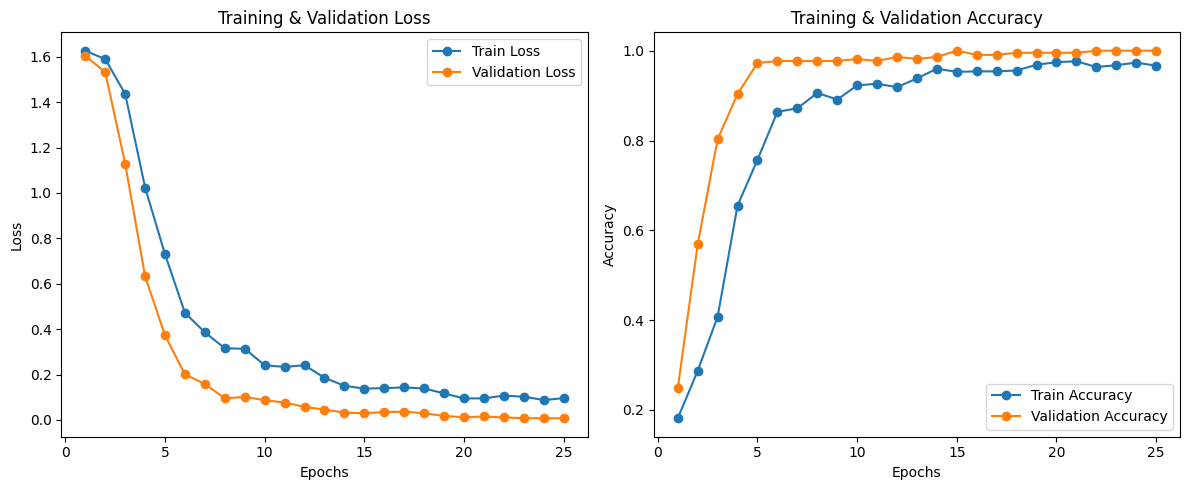

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# DATA_AUGMENTATION = False
DATA_AUGMENTATION = True

# === Preprocess Data ===
batch_size = 32

# Define the base transformation without augmentation
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = 'data/emotion_multiclass'
dataset = datasets.ImageFolder(root=data_dir, transform=base_transform)
# classes are in alphabetical order


# Split the dataset into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Test on a single image at a time

# === Define CNN Model ===
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # Adjust based on output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)  # Multiclass classification, Softmax is already applied by loss
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Create model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.classes)
model = EmotionCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()  # Multiclass classification loss, already applies softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Define Random Transformations for Augmentation ===
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation by 20 degrees
    transforms.RandomAffine(10),  # Random affine transformation
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# === Train the model ===
num_epochs = 25
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        
        if(DATA_AUGMENTATION):
            images = torch.stack([train_transforms(F.to_pil_image(image)) for image in images])  # Apply transformations
        else:
            images = torch.stack([base_transform(F.to_pil_image(image)) for image in images])

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss_val = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss_val / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

# === Save the model ===
torch.save(model.state_dict(), 'emotion_model_multiclass.pth')
print("Model saved successfully.")

# === Plot Loss and Accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

test

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import numpy as np

# === Define the CNN Model for Multi-class Classification ===
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),  # Multi-class classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x  # No Softmax here (handled during inference)

# === Load the pre-trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5  # Adjust based on your dataset (Happy, Sad, Anger, Neutral, Surprise)
model = EmotionCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('emotion_model_multiclass.pth'))  # Ensure you trained a multi-class model
model.eval()

# === Define Emotion Labels === (alphabetical order)
emotion_labels = ["Anger", "Happy", "Neutral", "Sad", "Surprise"]

# === Load OpenCV's pre-trained face detector ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# === OpenCV Webcam Capture ===
cap = cv2.VideoCapture(0)  # Use the first webcam
image_size = (64, 64)  # Input size for CNN

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to grayscale (required for face detection)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))

    for (x, y, w, h) in faces:
        # Crop and preprocess the face
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, image_size)

        # Convert face to tensor
        face_tensor = np.expand_dims(face_resized, axis=0)  # Add height & width dimension
        face_tensor = np.expand_dims(face_tensor, axis=0)  # Add channel dimension (1)
        face_tensor = torch.tensor(face_tensor, dtype=torch.float32) / 255  # Normalize
        face_tensor = face_tensor.to(device)

        # Get predictions
        with torch.no_grad():
            output = model(face_tensor)
            probabilities = torch.softmax(output, dim=1)  # Apply softmax
            predicted_class = torch.argmax(probabilities, dim=1).item()

        # Map prediction to emotion label
        emotion = emotion_labels[predicted_class]

        # Draw a rectangle around the face and display the emotion label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'Emotion: {emotion}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Show the frame with the face detection and emotion label
    cv2.imshow('Emotion Detection', frame)

    # Break the loop when the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()
